In [30]:
#as i'm working alone, i did all by myself :)
import csv
import random
import matplotlib.pyplot as plt


In [10]:
#ex1 
def load_records(file_path):
    """
    Load student records from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        list: List of student records (each record is a dict).
    """
    records = []
    with open(file_path, 'r') as file:
        headers = file.readline().strip().split(",")
        for line in file:
            values = line.strip().split(",")
            record = dict(zip(headers, values))
            records.append(record)
    return records


def compute_average(records):
    """
    Compute the average grade.

    Args:
        records (list): Student records.

    Returns:
        float: Average grade.
    """
    total = sum(float(r['Grade']) for r in records)
    return total / len(records)


def filter_records(records, threshold=80.0):
    """
    Filter students by grade threshold.

    Args:
        records (list): Student records.
        threshold (float, optional): Minimum grade. Defaults to 80.0.

    Returns:
        list: Filtered student records.
    """
    return [r for r in records if float(r['Grade']) >= threshold]


def print_report(records):
    """
    Print the student report.

    Args:
        records (list): Filtered student records.
    """
    print("Student Report")
    print("--------------")
    for r in records:
        print(f"{r['Name']} - {r['Grade']}")


def run_pipeline(file_path, threshold=80.0):
    """
    Run the pipeline: load, compute average, filter, and print report.

    Args:
        file_path (str): Path to the CSV file.
        threshold (float, optional): Grade threshold. Defaults to 80.0.
    """
    records = load_records(file_path)
    average = compute_average(records)
    print(f"Average Grade: {average:.2f}")
    print("--------------------")
    filtered = filter_records(records, threshold)
    print_report(filtered)


if __name__ == "__main__":
    print('run_pipeline("data/sample.csv", threshold=80.0)')



run_pipeline("data/sample.csv", threshold=80.0)


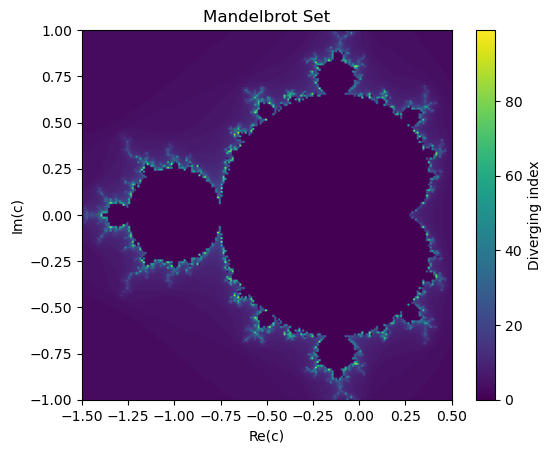

In [32]:
#ex2

def map_pixel_to_complex(px, py, width, x_min, x_max, y_min, y_max):
    """
    Map a pixel (px, py) to a complex number in the given ranges.
    """
    nx = px / float(width - 1)
    ny = py / float(width - 1)
    x = x_min + nx * (x_max - x_min)
    y = y_max - ny * (y_max - y_min)  # flip so top is y_max
    return complex(x, y)


def compute_diverge_index(c, max_iter=100):
    """
    Return diverging index (0 if non-diverging within max_iter).
    """
    a = 0+0j
    for n in range(1, max_iter):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 4.0:
            return n
    return 0


def draw_mandel(width):
    """
    plot Mandelbrot 
    """
    x_min, x_max = -1.5, 0.5
    y_min, y_max = -1.0, 1.0
    max_iter = 100

    image = []
    for py in range(width):
        row = []
        for px in range(width):
            c = map_pixel_to_complex(px, py, width, x_min, x_max, y_min, y_max)
            n = compute_diverge_index(c, max_iter=max_iter)
            row.append(n)
        image.append(row)

    plt.imshow(image, extent=(x_min, x_max, y_min, y_max))
    plt.colorbar(label="Diverging index")
    plt.title("Mandelbrot Set")
    plt.xlabel("Re(c)")
    plt.ylabel("Im(c)")
    plt.show()


# Example run
draw_mandel(200)



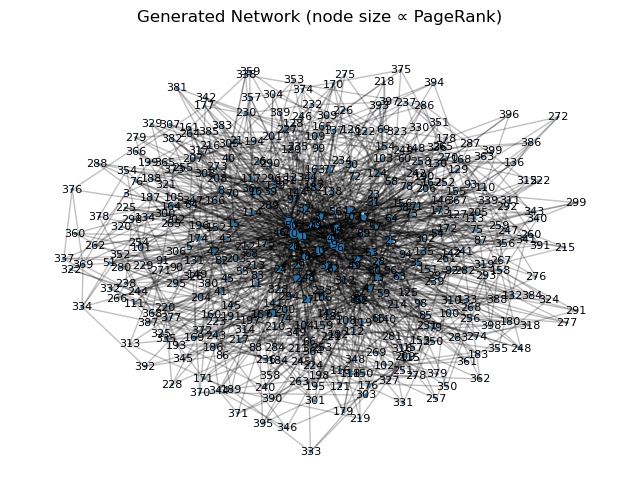

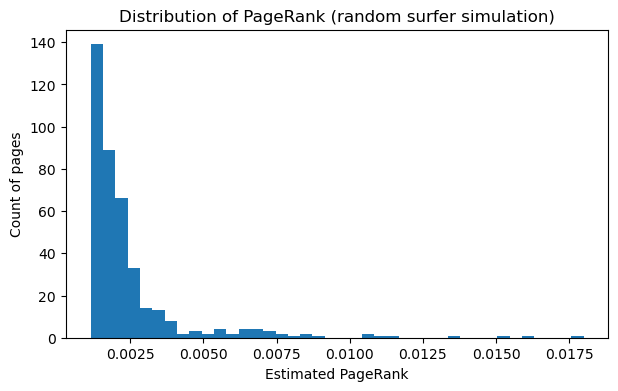

In [35]:

from __future__ import annotations

import random
from typing import Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


def make_star_graph(k: int, center: int = 0) -> nx.Graph:
    """
    Create a star graph manually: one hub `center` connected to nodes 1..k.



    Args:
        k (int): Number of outer nodes connected to the hub (total nodes = k+1).
        center (int): Hub node id.

    Returns:
        nx.Graph: Star graph with nodes {center, 1..k}.

    Author(s): Team Member A
    """
    G = nx.Graph()
    G.add_node(center)
    for i in range(1, k + 1):
        G.add_node(i)
        G.add_edge(center, i)
    return G


def _weighted_choice(exclude: Iterable[int],
                     weights: Dict[int, float],
                     rng: random.Random) -> int:
    """
    Pick a node from `weights` (key: node, value: weight), excluding some nodes.

    Args:
        exclude (Iterable[int]): Nodes that cannot be chosen.
        weights (Dict[int, float]): Non-negative weights per node.
        rng (random.Random): RNG.

    Returns:
        int: Chosen node.

    Author(s): Team Member B
    """
    excl = set(exclude)
    items = [(u, w) for u, w in weights.items() if u not in excl and w > 0]
    if not items:
        raise ValueError("No available nodes to choose from.")

    nodes, ws = zip(*items)
    total = float(sum(ws))
    r = rng.random() * total
    acc = 0.0
    for u, w in items:
        acc += w
        if r <= acc:
            return u
    return nodes[-1]  # numerical safety


def preferential_attach_once(G: nx.Graph,
                             new_node: int,
                             M: int,
                             rng: Optional[random.Random] = None) -> None:
    """
    Add `new_node` to G and connect it to `M` **distinct** existing nodes with
    probability proportional to their degree (Barabási–Albert step).
    Self-links and duplicate links are disallowed.

    Args:
        G (nx.Graph): Existing graph (non-empty).
        new_node (int): Id of the new node.
        M (int): Number of attachments to distinct existing nodes.
        rng (random.Random, optional): RNG (for reproducibility).

    Returns:
        None

    Author(s): Team Member B
    """
    if rng is None:
        rng = random.Random()

    if new_node in G:
        raise ValueError(f"Node {new_node} already in graph.")
    if G.number_of_nodes() < 1:
        raise ValueError("Graph must already have at least one node.")
    if M < 1:
        raise ValueError("M must be >= 1.")
    if M > G.number_of_nodes():
        raise ValueError("M cannot exceed number of existing nodes.")

    G.add_node(new_node)

    # Recompute degree weights dynamically after each attachment (without replacement)
    chosen: List[int] = []
    for _ in range(M):
        degrees = dict(G.degree())  # degree for all nodes (including new node)
        # Only existing nodes (exclude new_node and already chosen)
        weights = {u: float(d) for u, d in degrees.items() if u != new_node}
        u = _weighted_choice(exclude=chosen, weights=weights, rng=rng)
        G.add_edge(new_node, u)
        chosen.append(u)


def build_ba_network(k: int,
                     N: int,
                     M: int,
                     seed: Optional[int] = None) -> nx.Graph:
    """
    Build a BA network from scratch:
      1) Start with a manual star on nodes {0..k}, hub=0
      2) For new nodes v = k+1..N-1, attach to M existing nodes
         via degree-proportional preferential attachment.

    Args:
        k (int): Initial star has k leaves (total k+1 nodes).
        N (int): Final number of nodes in the network.
        M (int): Edges added by each new node (to distinct existing nodes).
        seed (int, optional): RNG seed for reproducibility.

    Returns:
        nx.Graph: The BA network.

    Author(s): Team Member A, Team Member B
    """
    if N < k + 1:
        raise ValueError("N must be at least k+1.")
    if M < 1 or M > (k + 1):
        # M can be at most initial node count to avoid early impossibility
        raise ValueError("M must be in [1, k+1].")

    rng = random.Random(seed)
    G = make_star_graph(k, center=0)

    for v in range(k + 1, N):
        preferential_attach_once(G, new_node=v, M=M, rng=rng)

    return G


def step_random_surfer(G: nx.Graph,
                       current: int,
                       alpha: float,
                       rng: Optional[random.Random] = None) -> int:
    """
    One step of the random surfer:
      - With prob alpha: jump uniformly to a neighbor of `current`.
      - With prob 1-alpha: jump uniformly to any non-neighbor (excluding self).
        If there are no non-neighbors (current connected to all), jump uniformly
        to any node except self.

    Args:
        G (nx.Graph): The web graph.
        current (int): Current node/page.
        alpha (float): Probability to follow a link on the page (0..1).
        rng (random.Random, optional): RNG.

    Returns:
        int: Next node.

    Author(s): Team Member C
    """
    if rng is None:
        rng = random.Random()

    neighbors = set(G.neighbors(current))
    all_nodes = set(G.nodes())
    non_neighbors = all_nodes - neighbors - {current}

    if rng.random() < alpha:
        # follow a link (if any), else fall back to any other node
        choices = list(neighbors) if neighbors else list(all_nodes - {current})
    else:
        # go to a non-linked page (if any), else any other node
        choices = list(non_neighbors) if non_neighbors else list(all_nodes - {current})

    return rng.choice(choices)


def simulate_pagerank(G: nx.Graph,
                      T: int,
                      alpha: float = 0.85,
                      start: Optional[int] = None,
                      seed: Optional[int] = None) -> Dict[int, float]:
    """
    Simulate PageRank by random surfing for T steps and return visit frequencies.

    Args:
        G (nx.Graph): The web graph.
        T (int): Number of steps (visits). Larger T => better estimate.
        alpha (float): Probability of following an on-page link.
        start (int, optional): Starting node (random if None).
        seed (int, optional): RNG seed.

    Returns:
        Dict[int, float]: Page -> estimated PageRank (visit count / T).

    Author(s): Team Member C
    """
    rng = random.Random(seed)
    nodes = list(G.nodes())
    if not nodes:
        return {}

    current = start if start is not None else rng.choice(nodes)
    visits = {u: 0 for u in nodes}

    for _ in range(T):
        visits[current] += 1
        current = step_random_surfer(G, current=current, alpha=alpha, rng=rng)

    total = float(T)
    return {u: visits[u] / total for u in nodes}


def plot_network(G: nx.Graph, pr: Dict[int, float]) -> None:
    """
    Plot the network; node sizes reflect PageRank.

    Args:
        G (nx.Graph): Graph to plot.
        pr (Dict[int, float]): PageRank estimates per node.

    Returns:
        None

    Author(s): Team Member D
    """
    # Scale node sizes by PR (min size safeguard)
    pr_vals = np.array([pr[u] for u in G.nodes()])
    sizes = 2000 * (pr_vals - pr_vals.min() + 1e-4)  # relative scaling

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=sizes)
    nx.draw_networkx_edges(G, pos, alpha=0.25)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Generated Network (node size ∝ PageRank)")
    plt.axis("off")
    plt.show()


def plot_pagerank_distribution(pr: Dict[int, float], bins: int = 30) -> None:
    """
    Plot a histogram of the PageRank estimates.

    Args:
        pr (Dict[int, float]): PageRank estimates per node.
        bins (int): Histogram bins.

    Returns:
        None

    Author(s): Team Member D
    """
    vals = np.array(list(pr.values()))
    plt.figure(figsize=(7, 4))
    plt.hist(vals, bins=bins)
    plt.xlabel("Estimated PageRank")
    plt.ylabel("Count of pages")
    plt.title("Distribution of PageRank (random surfer simulation)")
    plt.show()


def run_pipeline(k: int = 5, N: int = 400, M: int = 4,
                 T: int = 200_000, alpha: float = 0.85,
                 seed: Optional[int] = 123) -> Tuple[nx.Graph, Dict[int, float]]:
    """
    Orchestrate: build BA network and simulate PageRank; then plot both views.

    Args:
        k (int): Initial star leaves (total initial nodes k+1).
        N (int): Final number of pages.
        M (int): New edges per added page (to distinct existing pages).
        T (int): Random surfer steps.
        alpha (float): Link-follow probability.
        seed (int, optional): RNG seed.

    Returns:
        Tuple[nx.Graph, Dict[int, float]]: (Graph, PageRank map)

    Author(s): Everyone
    """
    G = build_ba_network(k=k, N=N, M=M, seed=seed)
    pr = simulate_pagerank(G, T=T, alpha=alpha, start=None, seed=seed)
    # Visualizations
    plot_network(G, pr)
    plot_pagerank_distribution(pr, bins=40)
    return G, pr


if __name__ == "__main__":
    # Default run for the assignment:
    #   N = 400 pages, M = 4 links per new page, start from k = 5 star
    run_pipeline(k=5, N=400, M=4, T=100_000, alpha=0.85, seed=52)


In [43]:
#ex3.2

def load_edges_csv(path):
    """
    Load edges from a 2-column CSV (source,target) with header.

    Args:
        path (str): Path to 'squirrel_edges.csv'.

    Returns:
        list: List of (source, target) pairs as strings.
    """
    edges = []
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader, None)
        for row in reader:
            if len(row) >= 2:
                u, v = row[0].strip(), row[1].strip()
                if u and v and u != v:  # skip empties and self-links
                    edges.append((u, v))
    return edges



In [36]:
def make_graph(edges, directed=True):
    """
    Build a lightweight graph structure.

    Args:
        edges (list): List of (u, v) edges (strings or ints).
        directed (bool): If True, store only u->v; if False, add both directions.

    Returns:
        dict: Graph dict with keys:
              - 'directed' : bool
              - 'nodes'    : set of nodes
              - 'out'      : dict node -> list of out-neighbors
    """
    nodes = set()
    out = {}
    def add_edge(a, b):
        if a not in out:
            out[a] = []
        out[a].append(b)

    for u, v in edges:
        nodes.add(u); nodes.add(v)
        add_edge(u, v)
        if not directed:
            add_edge(v, u)

    # Ensure every node appears in out (dangling nodes -> empty list)
    for n in list(nodes):
        if n not in out:
            out[n] = []

    return {"directed": directed, "nodes": nodes, "out": out}



In [37]:
def get_neighbors(G, node):
    """
    Get neighbors for current node.

    Args:
        G (dict): Graph dict.
        node: Current node.

    Returns:
        list: Neighbor list (outgoing for directed, undirected neighbors otherwise).
    """
    return G["out"].get(node, [])


In [38]:
def get_non_neighbors(G, node):
    """
    Compute non-neighbors excluding the node itself.

    Args:
        G (dict): Graph dict.
        node: Node.

    Returns:
        list: List of nodes that are NOT neighbors of `node` and not `node`.
    """
    neighbors = set(get_neighbors(G, node))
    return [u for u in G["nodes"] if (u != node and u not in neighbors)]


In [39]:
def step_random_surfer(G, current, alpha=0.85, rng=None):
    """
    One step of the random surfer that works for directed and undirected graphs.

    Directed:
        - With prob alpha: pick a random OUT-neighbor of current (if any).
        - Otherwise (or if no out-neighbors): jump to a random node != current.

    Undirected:
        - With prob alpha: pick a random neighbor (if any, else any other node).
        - With prob 1-alpha: pick a random non-neighbor (if any, else any other node).

    Args:
        G (dict): Graph dict from make_graph.
        current: Current node.
        alpha (float): Link-follow probability (0..1).
        rng (random.Random, optional): RNG.

    Returns:
        Node: Next node.
    """
    if rng is None:
        rng = random.Random()

    nodes = list(G["nodes"])
    others = [u for u in nodes if u != current]
    if not others:  # single-node graph
        return current

    neighbors = list(get_neighbors(G, current))
    if G["directed"]:
        follow = (rng.random() < alpha) and len(neighbors) > 0
        if follow:
            return rng.choice(neighbors)
        return rng.choice(others)
    else:
        non_neighbors = get_non_neighbors(G, current)
        if rng.random() < alpha:
            choices = neighbors if neighbors else others
        else:
            choices = non_neighbors if non_neighbors else others
        return rng.choice(choices)


In [40]:
def simulate_pagerank(G, T, alpha=0.85, start=None, seed=None):
    """
    Simulate PageRank via random surfing for T steps and return visit frequencies.

    Args:
        G (dict): Graph dict from make_graph.
        T (int): Number of surfer steps (larger => better estimate).
        alpha (float): Link-follow probability.
        start: Optional starting node; if None, random start.
        seed (int, optional): RNG seed.

    Returns:
        dict: node -> estimated PageRank (visits / T), sums to ~1.
    """
    rng = random.Random(seed)
    nodes = list(G["nodes"])
    if not nodes or T <= 0:
        return {}

    current = start if start in G["nodes"] else rng.choice(nodes)
    visits = {u: 0 for u in nodes}

    for _ in range(T):
        visits[current] += 1
        current = step_random_surfer(G, current=current, alpha=alpha, rng=rng)

    total = float(T)
    return {u: visits[u] / total for u in nodes}


In [41]:
def plot_pagerank_distribution(pr, bins=40, title="PageRank distribution"):
    """
    Plot a histogram of PageRank estimates.

    Args:
        pr (dict): node -> PageRank probability.
        bins (int): Number of histogram bins.
        title (str): Plot title.

    Returns:
        None
    """
    vals = list(pr.values())
    plt.figure(figsize=(7, 4))
    plt.hist(vals, bins=bins)
    plt.xlabel("Estimated PageRank")
    plt.ylabel("Count of pages")
    plt.title(title)
    plt.show()


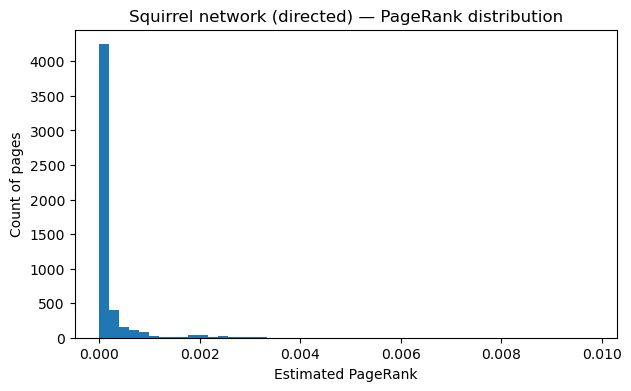

In [44]:
# 1) Load edges and build a directed graph
edges = load_edges_csv("squirrel_edges.csv")
G_dir = make_graph(edges, directed=True)

# 2) Simulate PageRank (random surfer)
pr_dir = simulate_pagerank(G_dir, T=300000, alpha=0.85, seed=42)

# 3) Visualize distribution
plot_pagerank_distribution(pr_dir, bins=50, title="Squirrel network (directed) — PageRank distribution")
